# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Remove duplicate imports and sort them alphabetically
import itertools
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
import warnings

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

import xgboost as xgb

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


SEASONAL_M = 12
SEED = 42
np.random.seed(SEED)


# Load and split

In [2]:
# --- Load and sort ---
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\Final.CSV")
df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)

# --- Define raw vars ---
target_raw = 'Total vehicles sold (Target)'
features_raw = [
    'Company car tax rate (%)',
    'Home charging (G)',
    'Consumer confidence (E)',
    'Gasoline (Euro95) - Average price (F)'
]

# --- Splits ---
n = len(df)
train_end = int(n * 0.8)
val_end   = int(n * 0.9)
idx_train, idx_val, idx_test = slice(0, train_end), slice(train_end, val_end), slice(val_end, n)

# --- Slice vars ---
def split_series(df, col):
    return {
        "train": df[col].iloc[idx_train].copy(),
        "val":   df[col].iloc[idx_val].copy(),
        "test":  df[col].iloc[idx_test].copy()
    }

y_raw_split = split_series(df, target_raw)
features_raw_split = {col: split_series(df, col) for col in features_raw}

# --- Print new names for transformed columns ---
print("Transformed column names:")
for col in features_raw + [target_raw]:
    suffix = "_yj" if 'consumer confidence' in col.lower() else "_bc"
    new_name = f"{col}{suffix}"
    print(new_name)

Transformed column names:
Company car tax rate (%)_bc
Home charging (G)_bc
Consumer confidence (E)_yj
Gasoline (Euro95) - Average price (F)_bc
Total vehicles sold (Target)_bc


# Visualize

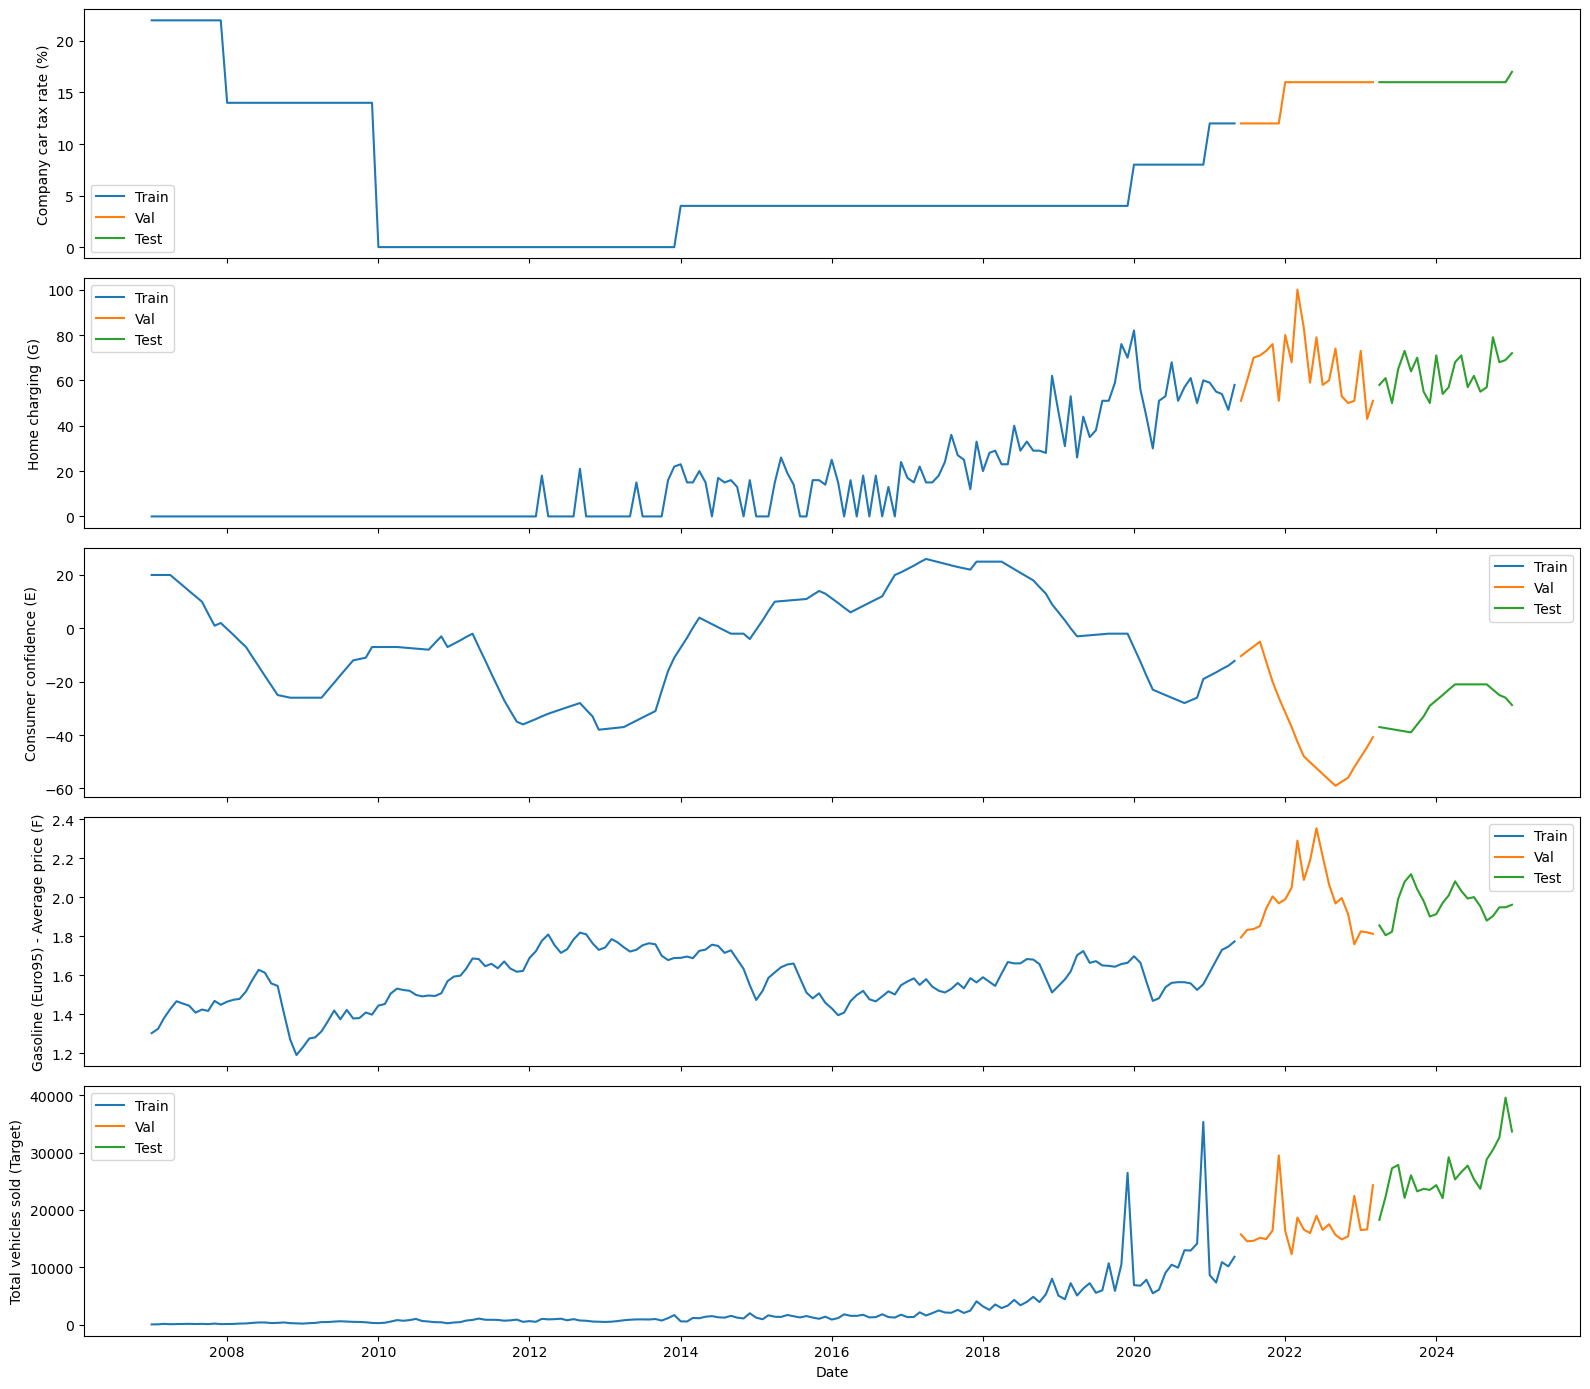

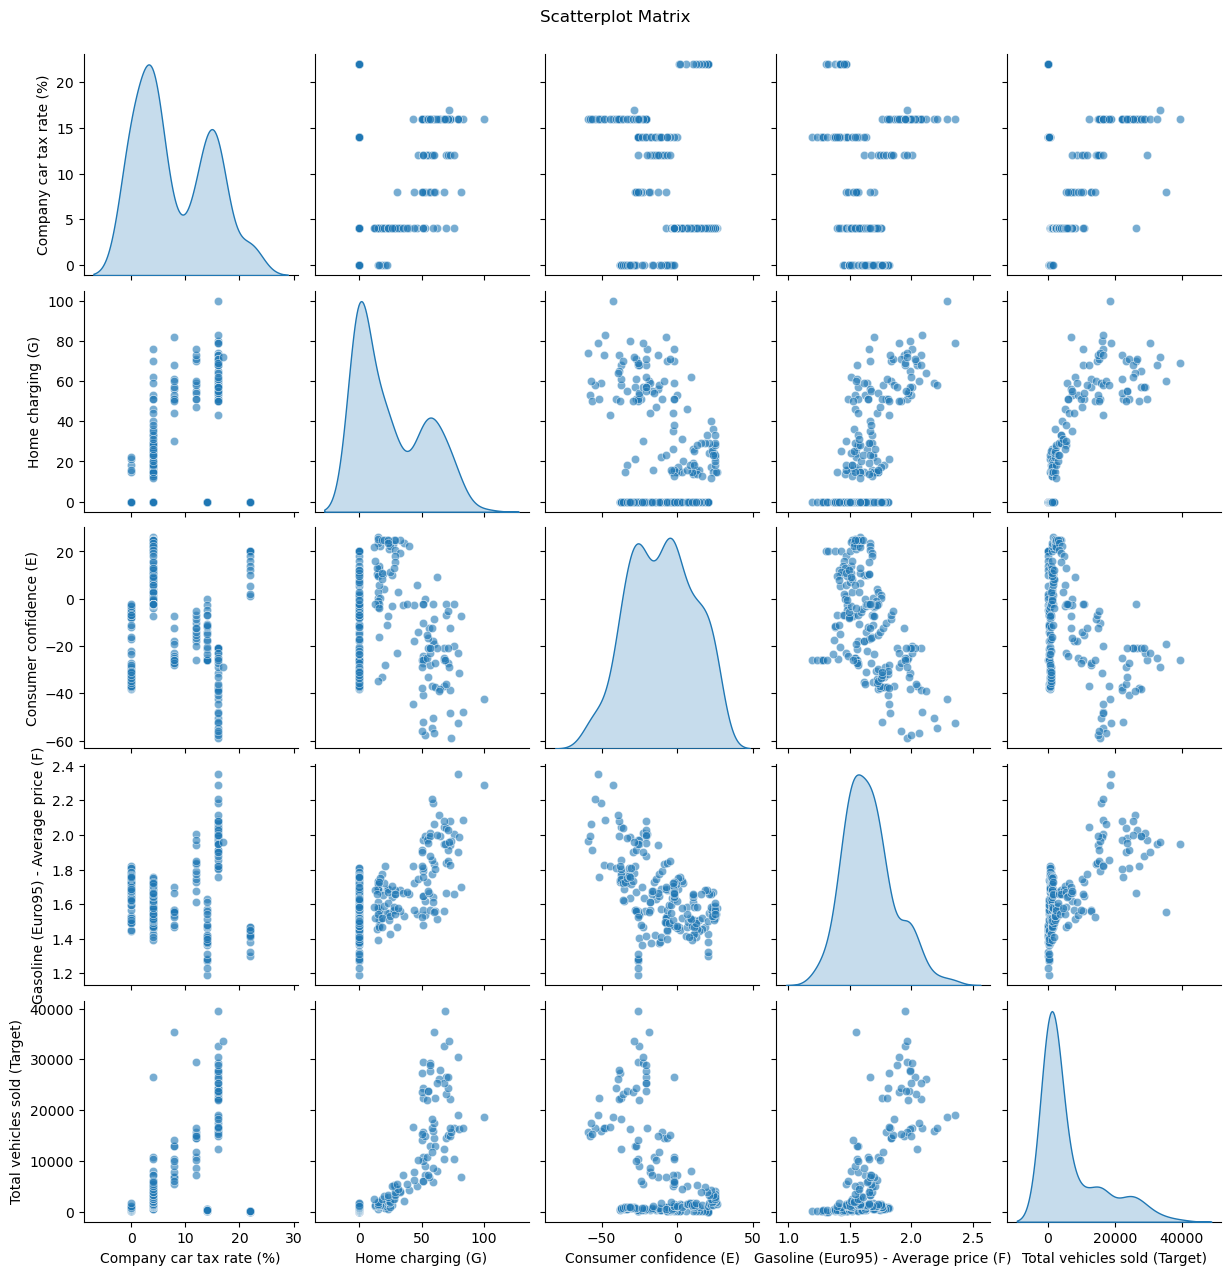

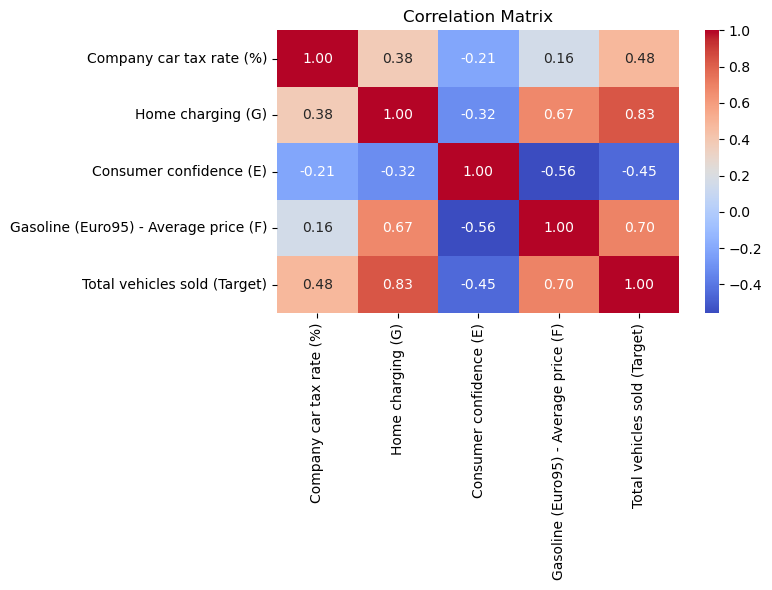

In [3]:
# --- Time series splits ---
fig, axs = plt.subplots(len(features_raw)+1, 1, figsize=(16, 14), sharex=True)

for i, col in enumerate(features_raw + [target_raw]):
    axs[i].plot(df["Time Period (T)"].iloc[idx_train], df[col].iloc[idx_train], label='Train')
    axs[i].plot(df["Time Period (T)"].iloc[idx_val],   df[col].iloc[idx_val],   label='Val')
    axs[i].plot(df["Time Period (T)"].iloc[idx_test],  df[col].iloc[idx_test],  label='Test')
    axs[i].set_ylabel(col)
    axs[i].legend()

axs[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

# --- Pairplot ---
sns.pairplot(df[features_raw + [target_raw]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix", y=1.02)
plt.show()

# --- Correlation matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(df[features_raw + [target_raw]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_kpss_summary(series, name):
    adf_stat, adf_p, *_ = adfuller(series, autolag='AIC', maxlag=12)
    kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags="auto")
    print(f"\033[1m{name}\033[0m")
    print(f"  ADF: stat={adf_stat:.3f}, p={adf_p:.3g} | {'Stationary' if adf_p < 0.05 else 'Non-stationary'}")
    print(f"  KPSS: stat={kpss_stat:.3f}, p={kpss_p:.3g} | {'Non-stationary' if kpss_p < 0.05 else 'Stationary'}\n")

print("=== Unit Root Tests on Train Splits ===")
for col in features_raw + [target_raw]:
    adf_kpss_summary(features_raw_split[col]["train"] if col in features_raw else y_raw_split["train"], col)


=== Unit Root Tests on Train Splits ===
Company car tax rate (%)
  ADF: stat=-2.418, p=0.137 | Non-stationary
  KPSS: stat=0.584, p=0.0241 | Non-stationary

Home charging (G)
  ADF: stat=0.083, p=0.965 | Non-stationary
  KPSS: stat=1.618, p=0.01 | Non-stationary

Consumer confidence (E)
  ADF: stat=-2.337, p=0.16 | Non-stationary
  KPSS: stat=0.328, p=0.1 | Stationary

Gasoline (Euro95) - Average price (F)
  ADF: stat=-3.250, p=0.0173 | Stationary
  KPSS: stat=0.507, p=0.04 | Non-stationary

Total vehicles sold (Target)
  ADF: stat=6.289, p=1 | Non-stationary
  KPSS: stat=1.296, p=0.01 | Non-stationary



C:\Users\dylan\AppData\Local\Temp\ipykernel_8704\1209334982.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags="auto")
C:\Users\dylan\AppData\Local\Temp\ipykernel_8704\1209334982.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags="auto")
C:\Users\dylan\AppData\Local\Temp\ipykernel_8704\1209334982.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags="auto")


# Data transformation
Box-Cox and Yeo-Johnson Transformations

In [5]:
from sklearn.preprocessing import PowerTransformer

def transform_series(series, method='box-cox'):
    shift = 0.0
    x = series.values.reshape(-1, 1).astype(float)  # Ensure float dtype
    if method == 'box-cox':
        min_val = x.min()
        if min_val <= 0:
            shift = -min_val + 1e-4
            x += shift
    pt = PowerTransformer(method=method, standardize=False)
    pt.fit(x)
    x_full = df[series.name].values.reshape(-1,1).astype(float)  # Ensure float dtype
    if shift != 0:
        x_full += shift
    transformed = pt.transform(x_full).flatten()
    return transformed, pt.lambdas_[0], shift

# --- Run transformations ---
transformed_data = {}
lambdas_all = {}
shifts_all = {}

for col in features_raw + [target_raw]:
    method = 'yeo-johnson' if 'consumer confidence' in col.lower() else 'box-cox'
    transformed, lam, shift = transform_series(df[col].iloc[idx_train], method)
    suffix = "_yj" if method == 'yeo-johnson' else "_bc"
    new_name = f"{col}{suffix}"
    transformed_data[new_name] = transformed
    lambdas_all[col] = lam
    shifts_all[col] = shift

# --- Build new DataFrame ---
df_trans = pd.DataFrame(transformed_data)
df_trans["Time Period (T)"] = df["Time Period (T)"]
df_trans = df_trans.sort_values("Time Period (T)").reset_index(drop=True)

## split on transformed data 

In [6]:
target_trans = [c for c in df_trans.columns if target_raw in c][0]
features_trans = [c for c in df_trans.columns if c != target_trans and "Time" not in c]

train_end_trans = int(len(df_trans) * 0.8)
val_end_trans   = int(len(df_trans) * 0.9)

idx_train_t, idx_val_t, idx_test_t = slice(0, train_end_trans), slice(train_end_trans, val_end_trans), slice(val_end_trans, len(df_trans))

y_trans_split = split_series(df_trans, target_trans)
features_trans_split = {col: split_series(df_trans, col) for col in features_trans}


## visualize transformed data


=== Box–Cox / Yeo–Johnson parameters and transformed series ===
Company car tax rate (%)_bc                   λ = 0.2205  shift = 0.0001


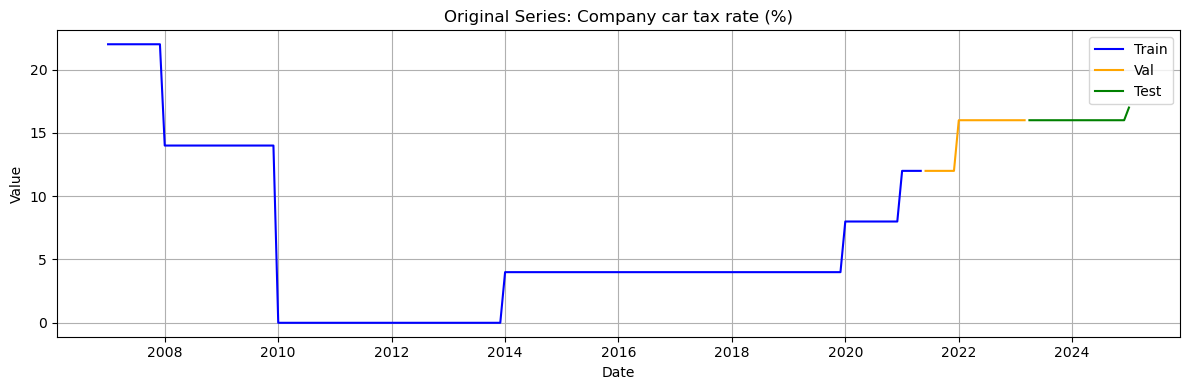

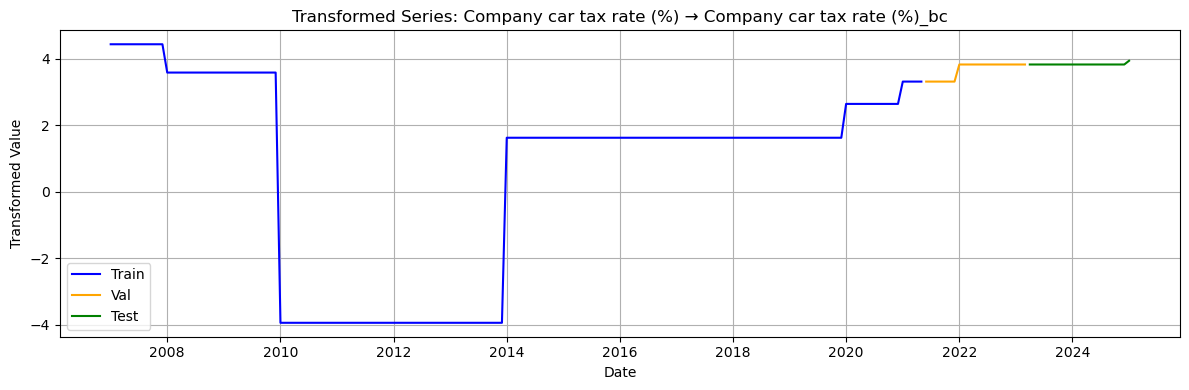

Home charging (G)_bc                          λ = -0.0268  shift = 0.0001


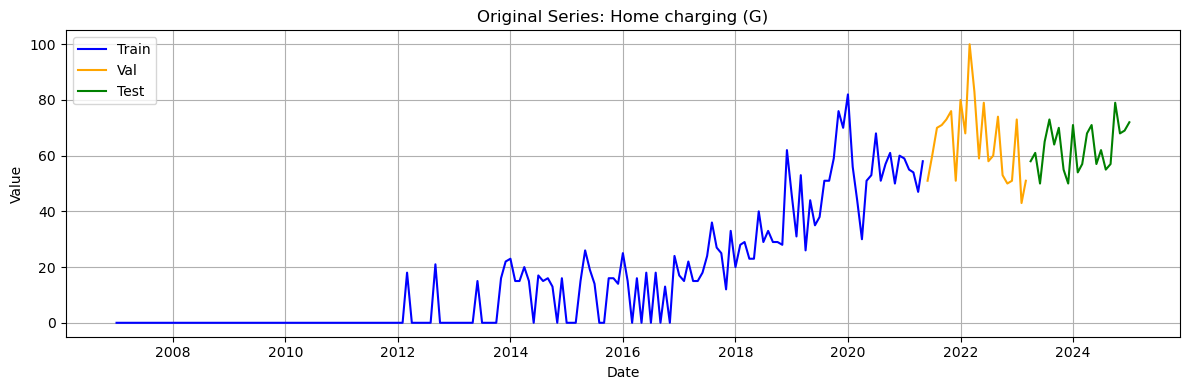

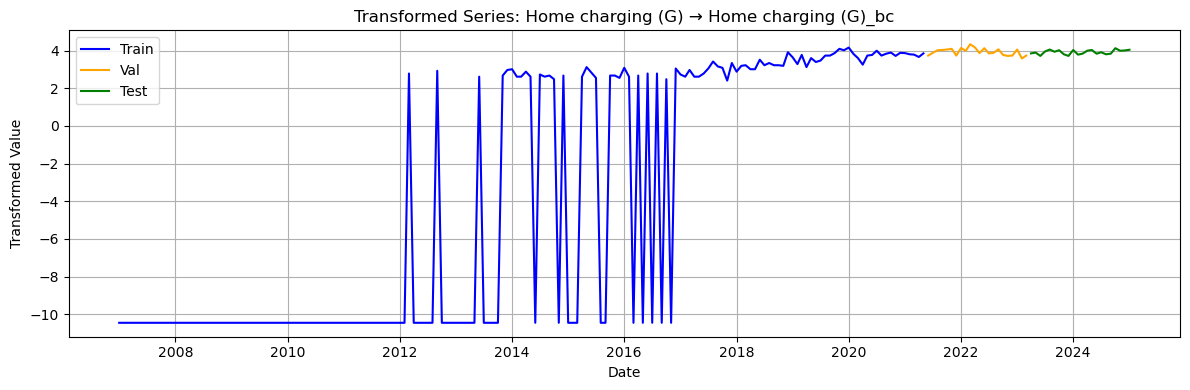

Consumer confidence (E)_yj                    λ = 1.0165  shift = 0


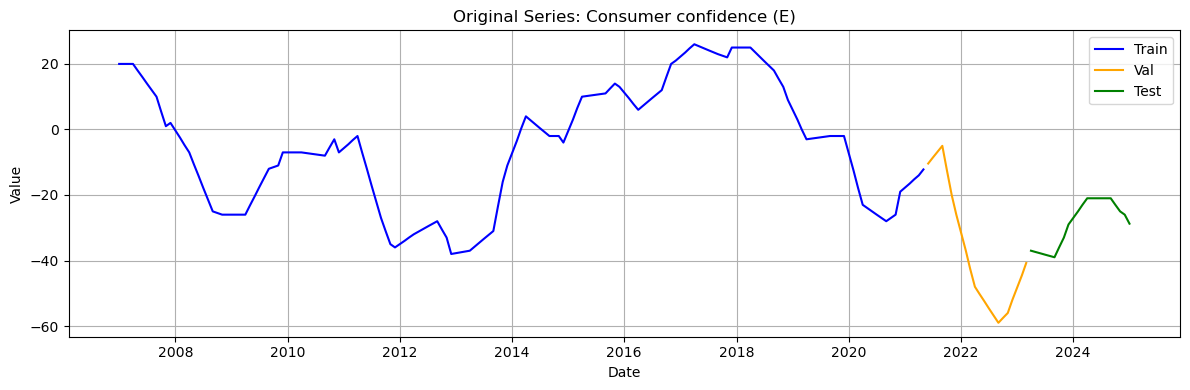

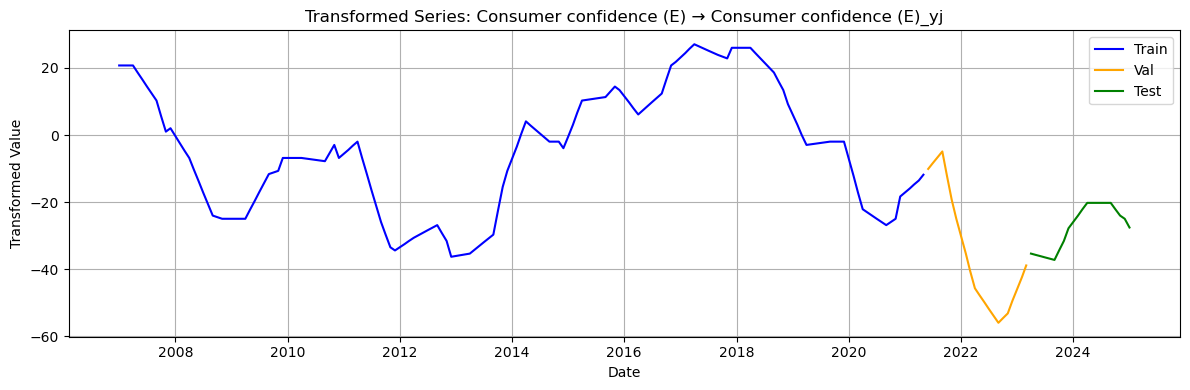

Gasoline (Euro95) - Average price (F)_bc      λ = 2.7450  shift = 0


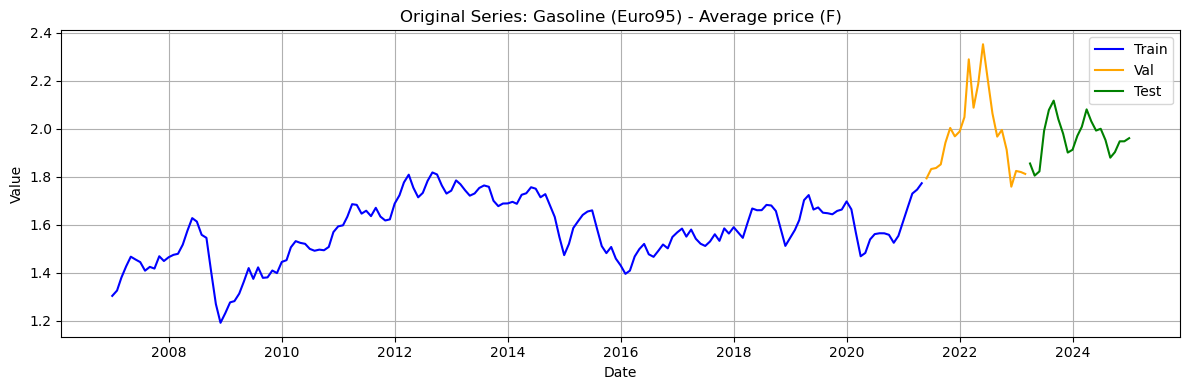

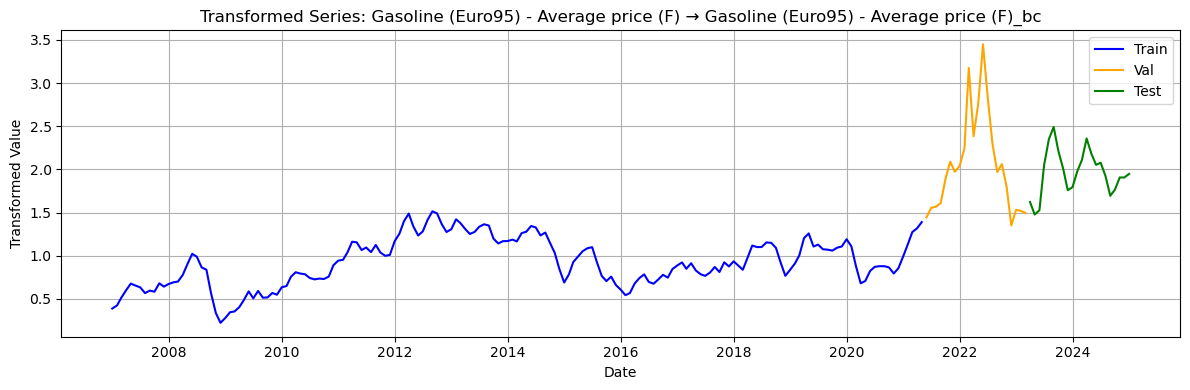

Total vehicles sold (Target)_bc               λ = -0.0017  shift = 0


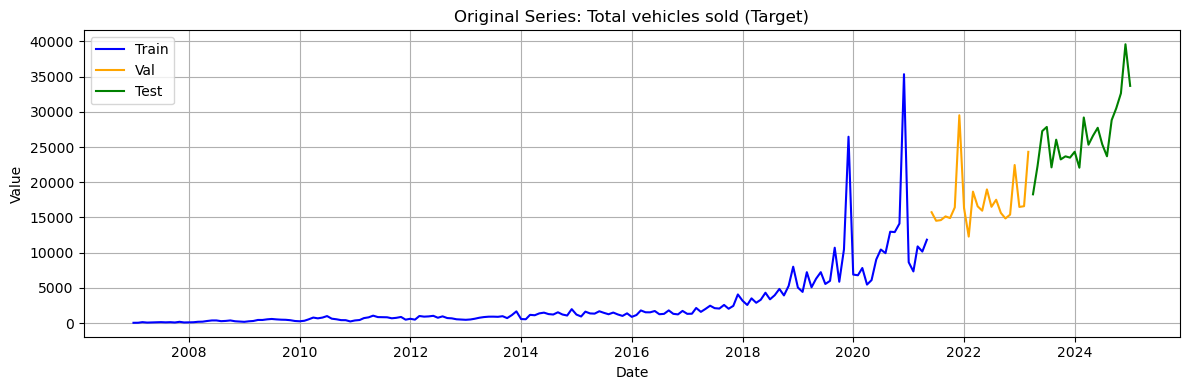

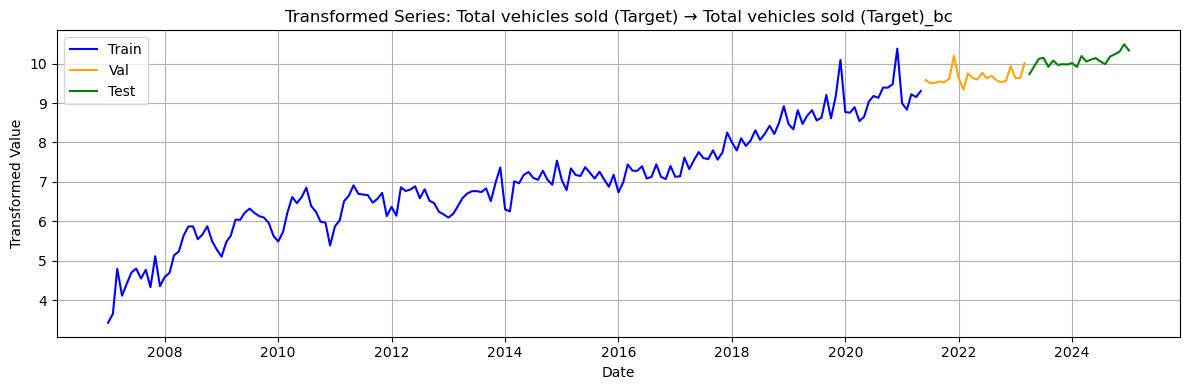

In [7]:
import matplotlib.pyplot as plt
from scipy import stats

print("\n=== Box–Cox / Yeo–Johnson parameters and transformed series ===")
time_index = df["Time Period (T)"]

for col in features_raw + [target_raw]:
    suffix = "_yj" if 'consumer confidence' in col.lower() else "_bc"
    new_name = f"{col}{suffix}"
    lam = lambdas_all[col]
    shift = shifts_all[col]

    print(f"{new_name:45s} λ = {lam:.4f}  shift = {shift:.4g}")

    # Apply shift to full series
    data_shifted = df[col] + shift

    # Apply transformation
    if suffix == "_bc":
        transformed = stats.boxcox(data_shifted, lmbda=lam)
    else:
        transformed = stats.yeojohnson(data_shifted, lmbda=lam)

    # --- Plot original series ---
    plt.figure(figsize=(12, 4))
    plt.plot(time_index.iloc[:train_end], df[col].iloc[:train_end], label="Train", color="blue")
    plt.plot(time_index.iloc[train_end:val_end], df[col].iloc[train_end:val_end], label="Val", color="orange")
    plt.plot(time_index.iloc[val_end:], df[col].iloc[val_end:], label="Test", color="green")
    plt.title(f"Original Series: {col}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot transformed series ---
    plt.figure(figsize=(12, 4))
    plt.plot(time_index.iloc[:train_end], transformed[:train_end], label="Train", color="blue")
    plt.plot(time_index.iloc[train_end:val_end], transformed[train_end:val_end], label="Val", color="orange")
    plt.plot(time_index.iloc[val_end:], transformed[val_end:], label="Test", color="green")
    plt.title(f"Transformed Series: {col} → {new_name}")
    plt.xlabel("Date")
    plt.ylabel("Transformed Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Benchmark test 

                               Value
Metric                              
Naïve_MSE_orig           28740226.95
Naïve_RMSE_orig              5360.99
Naïve_MAE_orig               3615.55
Naïve_MAPE_orig                 0.19
SeasonalNaïve_MSE_orig   19861440.65
SeasonalNaïve_RMSE_orig      4456.62
SeasonalNaïve_MAE_orig       3741.55
SeasonalNaïve_MAPE_orig         0.21
Drift_MSE_orig           24186595.98
Drift_RMSE_orig              4917.99
Drift_MAE_orig               3498.07
Drift_MAPE_orig                 0.20


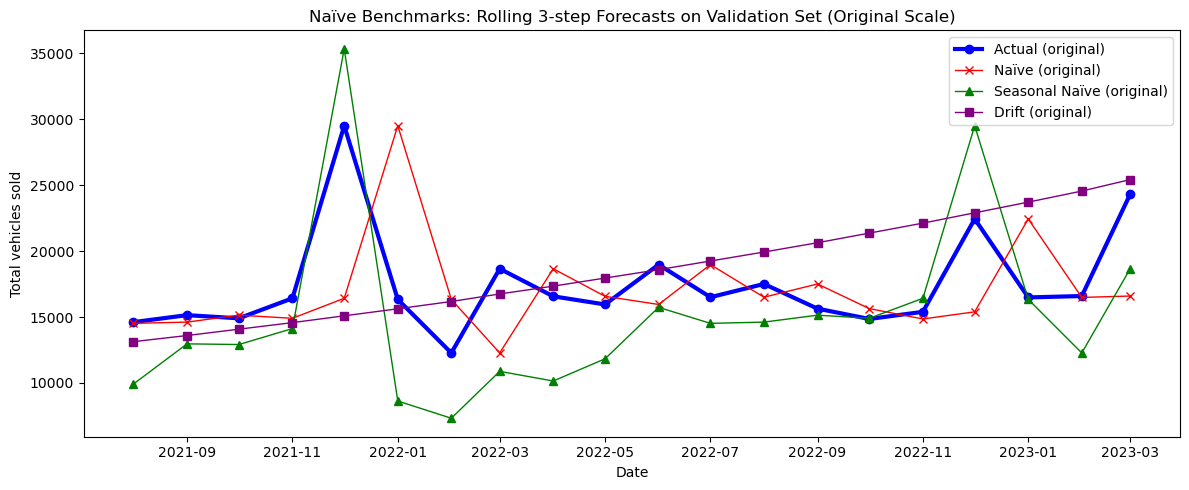


=== Metrics on transformed scale (no backtransform) ===
                          Value
Metric                         
Naïve_MSE_trans            0.07
Naïve_RMSE_trans           0.26
Naïve_MAE_trans            0.19
Naïve_MAPE_trans           0.02
SeasonalNaïve_MSE_trans    0.09
SeasonalNaïve_RMSE_trans   0.30
SeasonalNaïve_MAE_trans    0.24
SeasonalNaïve_MAPE_trans   0.03
Drift_MSE_trans            0.06
Drift_RMSE_trans           0.25
Drift_MAE_trans            0.19
Drift_MAPE_trans           0.02


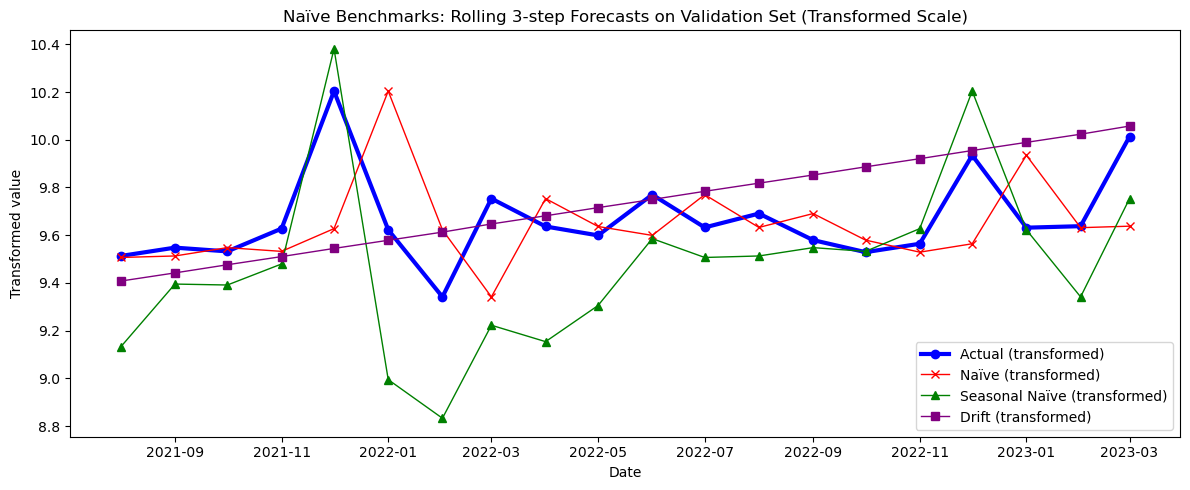

In [12]:
# --- 1. Bereid data ---
from scipy.special import inv_boxcox

h = 3
val_bc = y_trans_split["val"]
train_bc = y_trans_split["train"]
y_all_bc = np.concatenate([train_bc.values, val_bc.values])
val_bc_full = val_bc.values
n_train_bc = len(train_bc)

lam_bc = lambdas_all[target_raw]
shift_bc = shifts_all[target_raw]

# --- 2. Maak voorspellingen ---
actuals_bc = val_bc_full[h-1:]

# Naïef
naive_preds_bc = np.array([
    y_all_bc[n_train_bc + t + h - 2]
    for t in range(len(val_bc_full) - h + 1)
])

# Seizoens-naïef
season_length = 12
seasonal_naive_preds_bc = np.array([
    y_all_bc[n_train_bc + t + h - 1 - season_length]
    if (n_train_bc + t + h - 1 - season_length) >= 0 else
    y_all_bc[n_train_bc + t + h - 2]
    for t in range(len(val_bc_full) - h + 1)
])

# Drift
drift_preds_bc = np.array([
    train_bc.values[-1] + ((n_train_bc + t + h - 1 - (n_train_bc - 1)) * (train_bc.values[-1] - train_bc.values[0]) / (n_train_bc - 1))
    for t in range(len(val_bc_full) - h + 1)
])

# --- 3. Functie definieren ---
def benchmark_metrics(y_true, y_pred, label, lam, shift):
    y_true_orig = inv_boxcox(y_true, lam) - shift
    y_pred_orig = inv_boxcox(y_pred, lam) - shift
    return {
        f"{label}_MSE_orig": mean_squared_error(y_true_orig, y_pred_orig),
        f"{label}_RMSE_orig": np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)),
        f"{label}_MAE_orig": mean_absolute_error(y_true_orig, y_pred_orig),
        f"{label}_MAPE_orig": mean_absolute_percentage_error(y_true_orig, y_pred_orig)
    }
# --- 4. Evaluatie ---
naive_metrics   = benchmark_metrics(actuals_bc, naive_preds_bc, "Naïve", lam_bc, shift_bc)
seasonal_metrics = benchmark_metrics(actuals_bc, seasonal_naive_preds_bc, "SeasonalNaïve", lam_bc, shift_bc)
drift_metrics    = benchmark_metrics(actuals_bc, drift_preds_bc, "Drift", lam_bc, shift_bc)

# --- 5. Samenvatting ---
metrics_df = pd.DataFrame([{
    **naive_metrics,
    **seasonal_metrics,
    **drift_metrics
}]).T
metrics_df.columns = ["Value"]
metrics_df.index.name = "Metric"
print(metrics_df.round(2))

# --- 6. Plot actuals and forecasts on the original (inverse-transformed) scale ---
x_dates_bc = df["Time Period (T)"].iloc[train_end + h - 1 : val_end]
actuals_orig = inv_boxcox(actuals_bc, lam_bc) - shift_bc
naive_preds_orig = inv_boxcox(naive_preds_bc, lam_bc) - shift_bc
seasonal_naive_preds_orig = inv_boxcox(seasonal_naive_preds_bc, lam_bc) - shift_bc
drift_preds_orig = inv_boxcox(drift_preds_bc, lam_bc) - shift_bc

plt.figure(figsize=(12, 5))
plt.plot(x_dates_bc, actuals_orig, label='Actual (original)', marker='o', color='blue', linewidth=3)
plt.plot(x_dates_bc, naive_preds_orig, label='Naïve (original)', marker='x', color='red', linewidth=1)
plt.plot(x_dates_bc, seasonal_naive_preds_orig, label='Seasonal Naïve (original)', marker='^', color='green', linewidth=1)
plt.plot(x_dates_bc, drift_preds_orig, label='Drift (original)', marker='s', color='purple', linewidth=1)
plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Validation Set (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# --- 7. Print and plot on transformed scale (no backtransform) ---
print("\n=== Metrics on transformed scale (no backtransform) ===")
def metrics_transformed(y_true, y_pred, label):
    return {
        f"{label}_MSE_trans": mean_squared_error(y_true, y_pred),
        f"{label}_RMSE_trans": np.sqrt(mean_squared_error(y_true, y_pred)),
        f"{label}_MAE_trans": mean_absolute_error(y_true, y_pred),
        f"{label}_MAPE_trans": mean_absolute_percentage_error(y_true, y_pred)
    }

naive_metrics_t = metrics_transformed(actuals_bc, naive_preds_bc, "Naïve")
seasonal_metrics_t = metrics_transformed(actuals_bc, seasonal_naive_preds_bc, "SeasonalNaïve")
drift_metrics_t = metrics_transformed(actuals_bc, drift_preds_bc, "Drift")

metrics_df_t = pd.DataFrame([{**naive_metrics_t, **seasonal_metrics_t, **drift_metrics_t}]).T
metrics_df_t.columns = ["Value"]
metrics_df_t.index.name = "Metric"
print(metrics_df_t.round(2))

plt.figure(figsize=(12, 5))
plt.plot(x_dates_bc, actuals_bc, label='Actual (transformed)', marker='o', color='blue', linewidth=3)
plt.plot(x_dates_bc, naive_preds_bc, label='Naïve (transformed)', marker='x', color='red', linewidth=1)
plt.plot(x_dates_bc, seasonal_naive_preds_bc, label='Seasonal Naïve (transformed)', marker='^', color='green', linewidth=1)
plt.plot(x_dates_bc, drift_preds_bc, label='Drift (transformed)', marker='s', color='purple', linewidth=1)
plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Validation Set (Transformed Scale)')
plt.xlabel('Date')
plt.ylabel('Transformed value')
plt.legend()
plt.tight_layout()
plt.show()

# Baseline model

## Auto Arima

In [14]:
# Install if necessary:
# pip install pmdarima xgboost
from pmdarima import auto_arima
from xgboost import XGBRegressor

# Optional exogenous features (use the same split as y) — set to None if not using exog
# Example:
# exog_train_bc = X_trans_split["train"].values  # shape (n_train, k)
# exog_val_bc   = X_trans_split["val"].values    # shape (n_val, k)
# exog_all_bc   = np.vstack([exog_train_bc, exog_val_bc])
exog_all_bc = None  # change if you have exogenous regressors

autoarima_preds_bc = []

for t in range(len(val_bc_full) - h + 1):
    # Last observed index before the target (aligns with your naive logic)
    window_end = n_train_bc + t + h - 2  # inclusive
    y_fit = y_all_bc[: window_end + 1]   # up to i = target - 1

    if exog_all_bc is not None:
        X_fit   = exog_all_bc[: window_end + 1]
        X_fore1 = exog_all_bc[window_end + 1 : window_end + 2]  # exog at the target time
    else:
        X_fit = X_fore1 = None

    arima = auto_arima(
        y=y_fit,
        X=X_fit,
        seasonal=True,
        m=season_length,
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore",
        trace=False,
        information_criterion="aicc",
        max_p=5, max_q=5, max_P=2, max_Q=2,
        max_d=2, max_D=1
    )

    # Predict exactly one step ahead to the target timestamp
    fc = arima.predict(n_periods=1, X=X_fore1)
    autoarima_preds_bc.append(fc[0])

autoarima_preds_bc = np.array(autoarima_preds_bc)

# Metrics on original scale
autoarima_metrics = benchmark_metrics(actuals_bc, autoarima_preds_bc, "AutoARIMA", lam_bc, shift_bc)

# Add to your metrics table
metrics_df = pd.concat([
    metrics_df,
    pd.DataFrame.from_dict(autoarima_metrics, orient="index", columns=["Value"])
])
print(metrics_df.round(2))

# Inverse transform for plotting (original scale)
autoarima_preds_orig = inv_boxcox(autoarima_preds_bc, lam_bc) - shift_bc

# Plots
plt.figure(figsize=(12, 5))
plt.plot(x_dates_bc, actuals_orig, label='Actual (original)', marker='o', color='blue', linewidth=3)
plt.plot(x_dates_bc, autoarima_preds_orig, label='AutoARIMA (original)', marker='d', color='orange', linewidth=1)
plt.title('AutoARIMA: Rolling h-step-aligned Forecasts on Validation Set (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Transformed-scale plot
plt.figure(figsize=(12, 5))
plt.plot(x_dates_bc, actuals_bc, label='Actual (Box–Cox)', marker='o', color='blue', linewidth=3)
plt.plot(x_dates_bc, autoarima_preds_bc, label='AutoARIMA (Box–Cox)', marker='d', color='orange', linewidth=1)
plt.title('AutoARIMA: Rolling h-step-aligned Forecasts on Validation Set (Box–Cox Scale)')
plt.xlabel('Date')
plt.ylabel('Transformed Value')
plt.legend()
plt.tight_layout()
plt.show()

# Add plot ACF, TIME PLOT, HISTOGRAM, 1Q-Q PLOT AND LJUNG-BOX

KeyboardInterrupt: 

## Manual tuning 

### plot train of target and ACF/PACF PLOT AND ADF/KPSS TEST 

### Difference data 
-   ACF/PACF PLOT AND ADF/KPSS TEST 

### test results and use aicC to search for better model

## XGBoost

In [ ]:
from xgboost import XGBRegressor

# --- Helper to make lag features for 1-step-ahead forecasting at time t+1 ---
def make_lag_features(y_arr, lags, exog_arr=None):
    """
    Builds features for predicting y[t+1] using lags of y at time t and optional exog at time t+1.
    Returns X, y_target, and the minimum index from which features are valid.
    """
    max_lag = max(lags)
    X_list, y_list = [], []

    for t in range(max_lag, len(y_arr) - 1):
        feats = []
        # y lags at time t
        for L in lags:
            feats.append(y_arr[t - L])
        # optional exog at target time (t+1) if known/available
        if exog_arr is not None:
            feats.extend(exog_arr[t + 1])  # exog for target time
        X_list.append(feats)
        y_list.append(y_arr[t + 1])       # next-step target

    X = np.asarray(X_list)
    y = np.asarray(y_list)
    start_idx = max_lag
    return X, y, start_idx

# Configure lags (include seasonal lags if monthly)
lags = [1, 2, 3, 6, 12]  # adjust as desired

xgb_preds_bc = []

for t in range(len(val_bc_full) - h + 1):
    # Last observed index before the target
    window_end = n_train_bc + t + h - 2  # inclusive
    y_fit_full = y_all_bc[: window_end + 1]

    # Optional exog for the entire observed range
    if exog_all_bc is not None:
        X_exog_full = exog_all_bc[: window_end + 1]
    else:
        X_exog_full = None

    # Build supervised dataset up to window_end (predicting t+1 within that window)
    X_train, y_train, start_idx = make_lag_features(y_fit_full, lags, exog_arr=X_exog_full)

    # If not enough data for lags, skip or continue
    if len(y_train) == 0:
        xgb_preds_bc.append(np.nan)
        continue

    # Train XGBoost
    xgb = XGBRegressor(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_train, y_train)

    # Construct the feature vector at time 'window_end' to predict 'window_end + 1'
    feats = []
    for L in lags:
        feats.append(y_fit_full[window_end - L])  # y lag values
    if X_exog_full is not None:
        # exog at target time (window_end + 1) must be available
        feats.extend(exog_all_bc[window_end + 1])

    x_pred = np.asarray(feats).reshape(1, -1)
    y_hat_1step = xgb.predict(x_pred)[0]
    xgb_preds_bc.append(y_hat_1step)

xgb_preds_bc = np.array(xgb_preds_bc)

# Metrics on original scale
xgb_metrics = benchmark_metrics(actuals_bc, xgb_preds_bc, "XGBoost", lam_bc, shift_bc)

# Add to your metrics table
metrics_df = pd.concat([
    metrics_df,
    pd.DataFrame.from_dict(xgb_metrics, orient="index", columns=["Value"])
])
print(metrics_df.round(2))

# Inverse transform for plotting
xgb_preds_orig = inv_boxcox(xgb_preds_bc, lam_bc) - shift_bc

# Plots (original scale)
plt.figure(figsize=(12, 5))
plt.plot(x_dates_bc, actuals_orig, label='Actual (original)', marker='o', color='blue', linewidth=3)
plt.plot(x_dates_bc, xgb_preds_orig, label='XGBoost (original)', marker='v', color='brown', linewidth=1)
plt.title('XGBoost: Rolling h-step-aligned Forecasts on Validation Set (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# Transformed-scale plot
plt.figure(figsize=(12, 5))
plt.plot(x_dates_bc, actuals_bc, label='Actual (Box–Cox)', marker='o', color='blue', linewidth=3)
plt.plot(x_dates_bc, xgb_preds_bc, label='XGBoost (Box–Cox)', marker='v', color='brown', linewidth=1)
plt.title('XGBoost: Rolling h-step-aligned Forecasts on Validation Set (Box–Cox Scale)')
plt.xlabel('Date')
plt.ylabel('Transformed Value')
plt.legend()
plt.tight_layout()
plt.show()
